# must cache_tmp first

In [1]:
from jupyter_imports import *

In [2]:
from riskpnl.post_trade import batch_summarize_exec_logs

rebuild = True
if rebuild:
    start = datetime(2022,6,23)#,tzinfo=timezone.utc)
    log_path = os.path.join(os.sep, 'tmp','prod','tradeexecutor')
    batch_summarize_exec_logs(log_path,start=start,add_history_context=False)
log_file = os.path.join(os.sep,'tmp','prod','tradeexecutor','all_by_symbol.csv')

original_weights = pd.read_csv(log_file).sort_values(by='log_time')
original_weights['log_time'] = original_weights['log_time'].apply(parser.parse)

In [3]:
original_weights.columns

Index(['Unnamed: 0', 'index', 'fee', 'filledUSD', 'slippage_bps',
       'time_to_execute', 'log_time'],
      dtype='object')

In [4]:
weights = original_weights#[original_weights['log_time']>start.replace(tzinfo=timezone.utc)]

weights['total_bps'] = weights['slippage_bps'] + weights['fee']/weights['filledUSD']*10000
weights['fee_USD'] = weights['fee']
weights['slippage_USD'] = weights['slippage_bps']*weights['filledUSD']/10000
weights['total_USD'] = weights['total_bps']*weights['filledUSD']/10000

### cumulative slippage and fees

In [5]:
trackrecord = weights[weights['index']=='average'].pivot_table(index='log_time',values=['fee_USD','slippage_USD','total_USD'],aggfunc=np.mean).cumsum()

In [6]:
trackrecord.iplot()

### slippage distribution

count      60.000000
mean      150.450843
std       524.807968
min      -151.461782
25%       -29.741821
50%         4.788192
75%        34.893654
max      2781.260324
Name: total_bps, dtype: float64

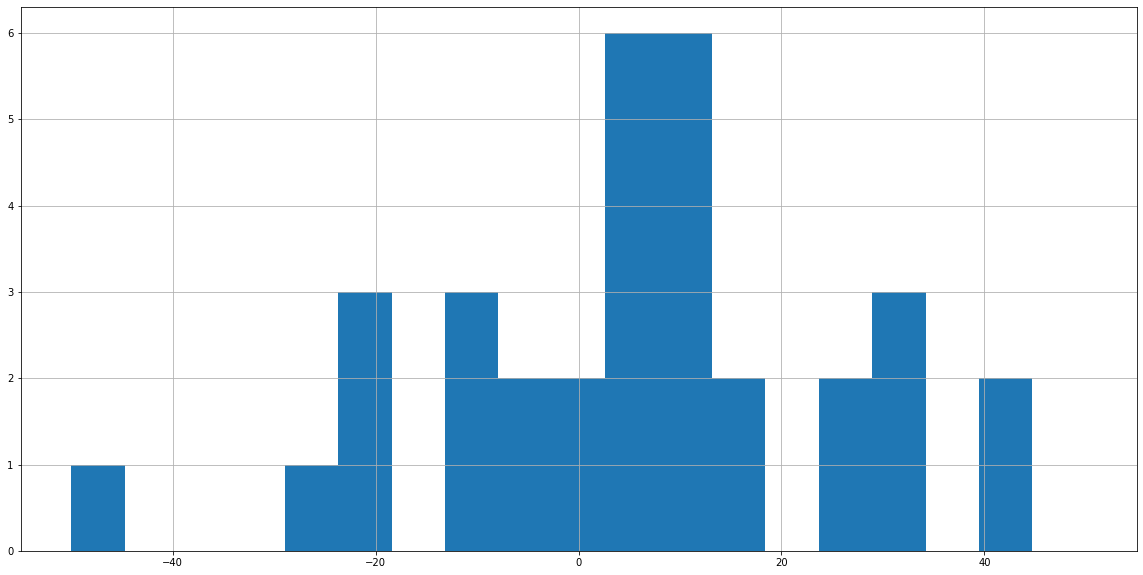

In [7]:
(weights.loc[weights['index']=='average','total_bps']).hist(bins=np.linspace(-50,50,20),figsize=(20,10))
weights.loc[weights['index']=='average','total_bps'].describe()

### weight history

In [8]:
request_file = os.path.join(os.sep,'tmp','prod','tradeexecutor','all_request.csv')
requests = pd.read_csv(request_file).sort_values(by='log_time')

In [9]:
requests.pivot_table(index='log_time',values=['fee_USD','slippage_USD','total_USD'])

KeyError: 'fee_USD'

In [ ]:
requests[~requests['index'].apply(lambda i: ':' in i)].pivot_table(index='log_time',values='target',columns='index').iplot()

In [ ]:
requests[~requests['index'].apply(lambda i: ':' in i)].pivot_table(index='log_time',values='diff',columns='index').iplot()